In [6]:
!python -m pip install -U setuptools pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# Check CUDA/cuDNN Version
!nvcc -V && which nvcc

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
/usr/local/cuda/bin/nvcc


In [8]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


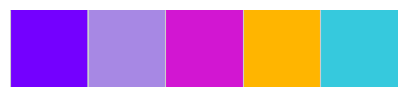

In [47]:
# Libraries
import os
import gc

import time
import random
import math
import glob
from scipy import spatial
from tqdm import tqdm
import warnings
import cv2
import pandas as pd
import numpy as np
from numpy import dot, sqrt
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from IPython.display import display_html
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
plt.rcParams.update({'font.size': 16})

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib.colors import ListedColormap
from utils import *

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Custom colors
class clr:
    S = '\033[1m' + '\033[95m'
    E = '\033[0m'
# Color Palette
custom_colors = ['#7400ff', '#a788e4', '#d216d2', '#ffb500', '#36c9dd']
sns.palplot(sns.color_palette(custom_colors))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

# Set tick size
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

In [11]:
covid_flu= pd.read_csv('covid_flu.csv')

print(clr.S+"COVID DATASET:"+clr.E, covid_flu.shape)
covid_flu.head().style.background_gradient(cmap = "Oranges")

COVID DATASET: (1482, 20)


/usr/local/lib/python3.9/dist-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.9/dist-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Diagnosis,InitialPCRDiagnosis,Age,Sex,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,CReactiveProteinLevels,DurationOfIllness,CTscanResults,RiskFactors,GroundGlassOpacity,Diarrhea,Fever,Coughing,ShortnessOfBreath,SoreThroat,NauseaVomitting,Temperature,Fatigue
0,H1N1,nan,67.000000,F,nan,nan,nan,nan,nan,nan,nan,nan,nan,Yes,Yes,nan,No,nan,38.111111,No
1,H1N1,nan,29.000000,M,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,H1N1,nan,22.000000,F,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,H1N1,nan,20.000000,F,nan,nan,nan,nan,nan,nan,immuno,nan,nan,Yes,Yes,nan,No,nan,36.555556,Yes
4,H1N1,nan,21.000000,M,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [12]:
covid_flu.shape, covid_flu.dtypes.value_counts(), covid_flu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482 entries, 0 to 1481
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Diagnosis                    1482 non-null   object 
 1   InitialPCRDiagnosis          104 non-null    object 
 2   Age                          1454 non-null   float64
 3   Sex                          1406 non-null   object 
 4   neutrophil                   103 non-null    float64
 5   serumLevelsOfWhiteBloodCell  151 non-null    float64
 6   lymphocytes                  156 non-null    float64
 7   CReactiveProteinLevels       137 non-null    object 
 8   DurationOfIllness            87 non-null     float64
 9   CTscanResults                159 non-null    object 
 10  RiskFactors                  209 non-null    object 
 11  GroundGlassOpacity           93 non-null     object 
 12  Diarrhea                     450 non-null    object 
 13  Fever             

((1482, 20),
 object     14
 float64     6
 dtype: int64,
 None)

In [13]:
# Data Information
print("Rows: {:,}".format(len(covid_flu)), "\n" +
      "Columns: {}".format(len(covid_flu.columns)))

# Find Missing Data if any
total = len(covid_flu)

for column in covid_flu.columns:
    if covid_flu[column].isna().sum() != 0:
        print("{} has: {:,} ({:.2}%) missing values.".format(column, covid_flu[column].isna().sum(), 
                                                             (covid_flu[column].isna().sum()/total)*100))

Rows: 1,482 
Columns: 20
InitialPCRDiagnosis has: 1,378 (9.3e+01%) missing values.
Age has: 28 (1.9%) missing values.
Sex has: 76 (5.1%) missing values.
neutrophil has: 1,379 (9.3e+01%) missing values.
serumLevelsOfWhiteBloodCell has: 1,331 (9e+01%) missing values.
lymphocytes has: 1,326 (8.9e+01%) missing values.
CReactiveProteinLevels has: 1,345 (9.1e+01%) missing values.
DurationOfIllness has: 1,395 (9.4e+01%) missing values.
CTscanResults has: 1,323 (8.9e+01%) missing values.
RiskFactors has: 1,273 (8.6e+01%) missing values.
GroundGlassOpacity has: 1,389 (9.4e+01%) missing values.
Diarrhea has: 1,032 (7e+01%) missing values.
Fever has: 559 (3.8e+01%) missing values.
Coughing has: 623 (4.2e+01%) missing values.
ShortnessOfBreath has: 1,407 (9.5e+01%) missing values.
SoreThroat has: 812 (5.5e+01%) missing values.
NauseaVomitting has: 1,061 (7.2e+01%) missing values.
Temperature has: 854 (5.8e+01%) missing values.
Fatigue has: 951 (6.4e+01%) missing values.


In [14]:
vars_to_impute = [var for var in covid_flu.columns if covid_flu[var].isnull().sum() > 0]

vars_to_impute, covid_flu.isnull().mean()

(['InitialPCRDiagnosis',
  'Age',
  'Sex',
  'neutrophil',
  'serumLevelsOfWhiteBloodCell',
  'lymphocytes',
  'CReactiveProteinLevels',
  'DurationOfIllness',
  'CTscanResults',
  'RiskFactors',
  'GroundGlassOpacity',
  'Diarrhea',
  'Fever',
  'Coughing',
  'ShortnessOfBreath',
  'SoreThroat',
  'NauseaVomitting',
  'Temperature',
  'Fatigue'],
 Diagnosis                      0.000000
 InitialPCRDiagnosis            0.929825
 Age                            0.018893
 Sex                            0.051282
 neutrophil                     0.930499
 serumLevelsOfWhiteBloodCell    0.898111
 lymphocytes                    0.894737
 CReactiveProteinLevels         0.907557
 DurationOfIllness              0.941296
 CTscanResults                  0.892713
 RiskFactors                    0.858974
 GroundGlassOpacity             0.937247
 Diarrhea                       0.696356
 Fever                          0.377193
 Coughing                       0.420378
 ShortnessOfBreath              0.9

In [15]:
covid_flu['Diagnosis'].value_counts(normalize=True)  # percent breakdown of response variable

H1N1       0.723347
COVID19    0.276653
Name: Diagnosis, dtype: float64

To that end, let’s write a function that takes in training and test data (listing 3.1), along with a feature engineering pipeline that we will assume will be a the scikit-learn Pipeline object that will do a few things:

- Instantiate an ExtraTreesClassifier model and a GridSearchCV instance.

- Fit our feature engineering pipeline to our training data.

- Transform our test data using the now-fit data pipeline.

- Do a quick hyperparameter search to find the set of parameters that gives us the best accuracy on our test set.

- Calculate a classification report on the testing data to see granular performance.

Return the best model.

In [16]:
numeric_types = ['float16', 'float32', 'float64', 'int16', 'int32', 'int64']  # the numeric types in Pandas

numerical_columns = covid_flu.select_dtypes(include=numeric_types).columns.tolist()

numerical_columns

['Age',
 'neutrophil',
 'serumLevelsOfWhiteBloodCell',
 'lymphocytes',
 'DurationOfIllness',
 'Temperature']

Mean: nan 
Median: nan 
Max: nan


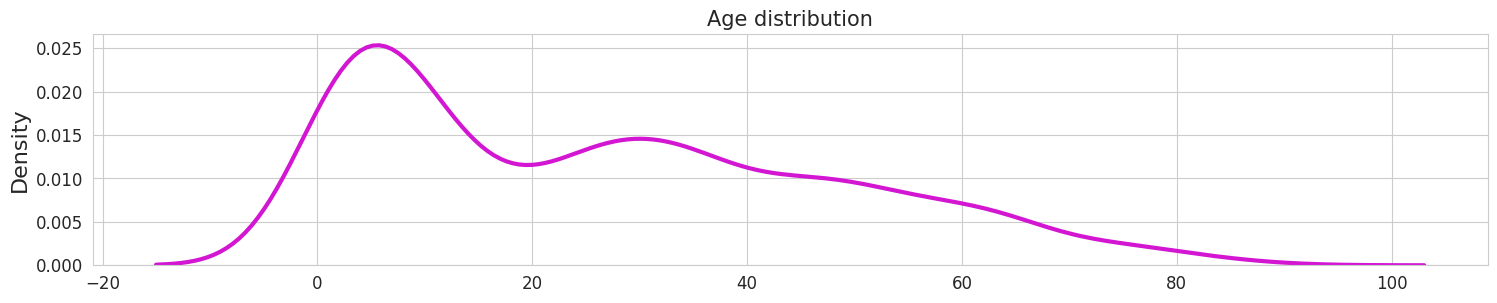

Mean: nan 
Median: nan 
Max: nan


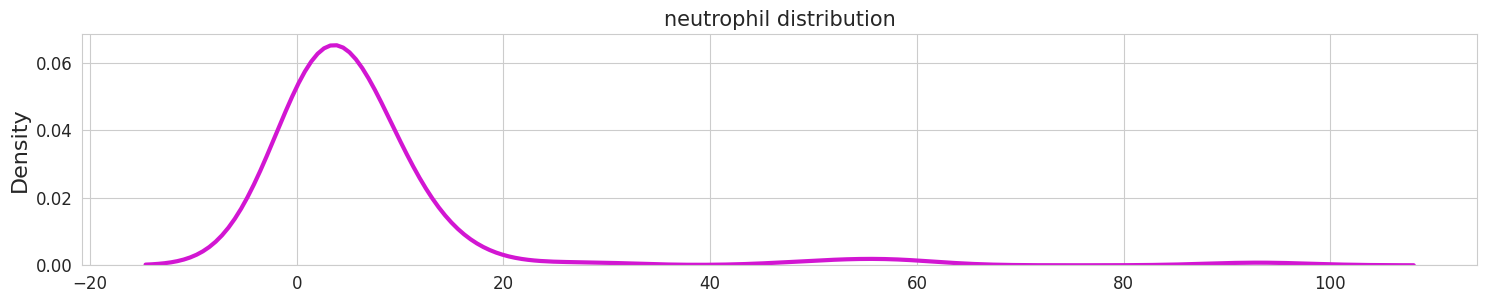

Mean: nan 
Median: nan 
Max: nan


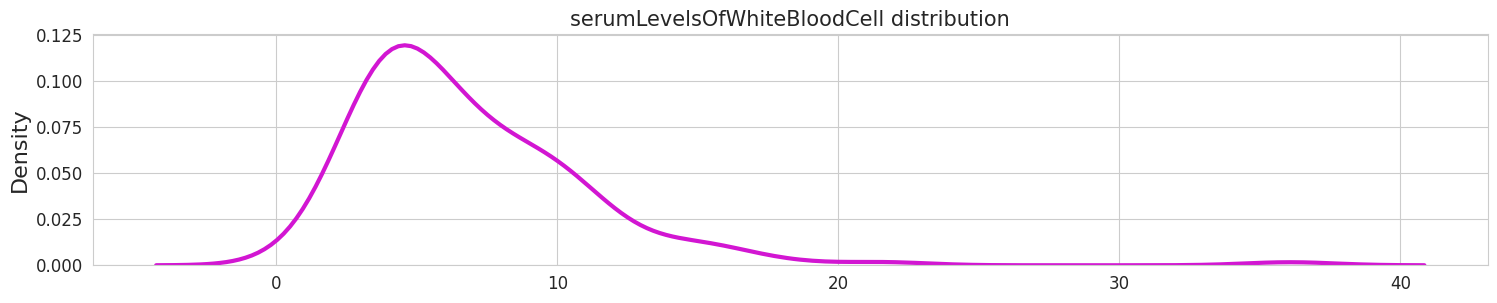

Mean: nan 
Median: nan 
Max: nan


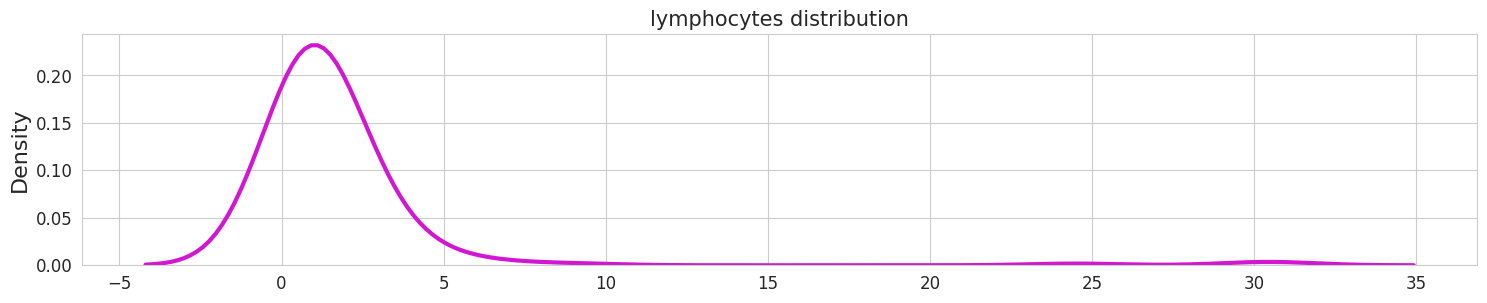

Mean: nan 
Median: nan 
Max: nan


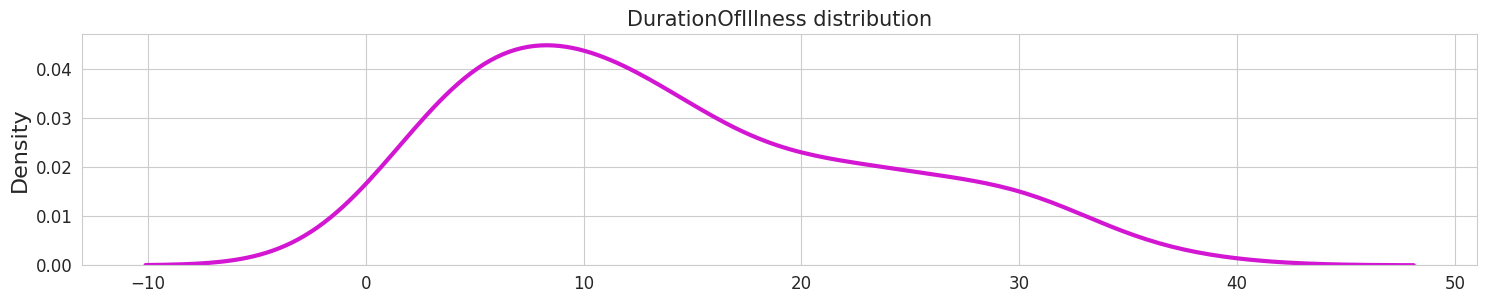

Mean: nan 
Median: nan 
Max: nan


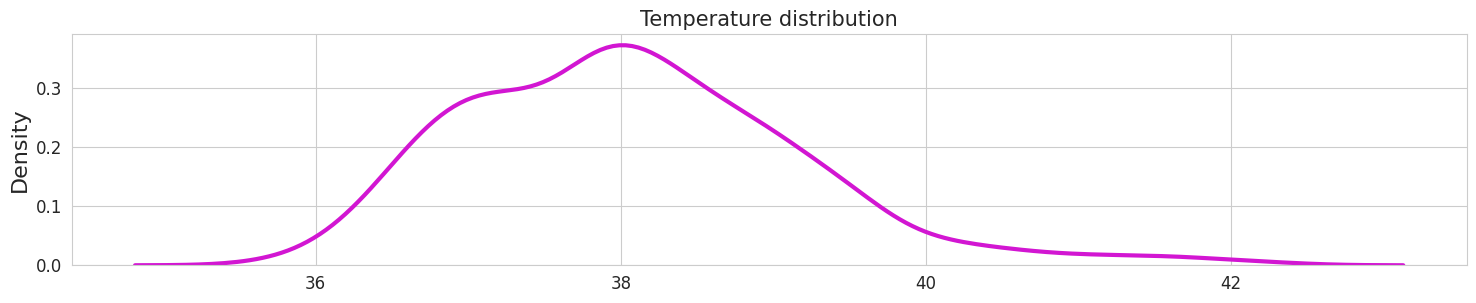

In [48]:
for feature in numerical_columns:
    distplot_features(covid_flu, feature=feature, title = feature + " distribution", color = custom_colors[2], categorical=False)

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'neutrophil'}>],
       [<Axes: title={'center': 'serumLevelsOfWhiteBloodCell'}>,
        <Axes: title={'center': 'lymphocytes'}>],
       [<Axes: title={'center': 'DurationOfIllness'}>,
        <Axes: title={'center': 'Temperature'}>]], dtype=object)

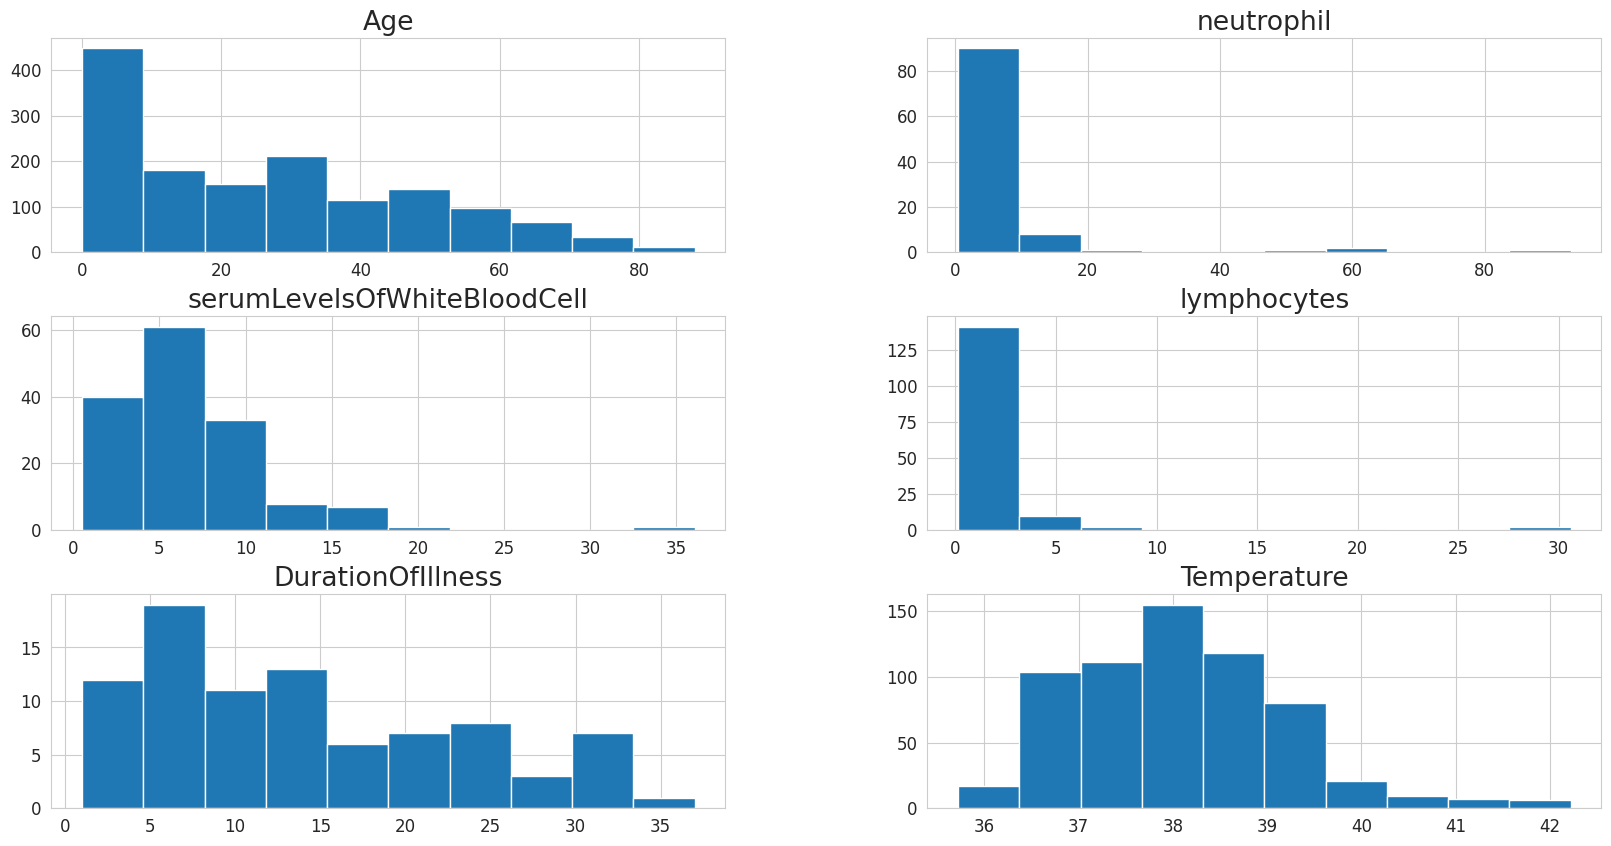

In [18]:
# looks like our numerical columns are hairly heavily right skewed

covid_flu[numerical_columns].hist(figsize=(20, 10))  

#MEAN/MEDIAN IMPUTATION

Our first option for numerical data imputation is to fill in all missing values with the mean or the median of the feature. To see this using scikit-learn, we can use the SimpleImputer:

In [19]:
from sklearn.impute import SimpleImputer  # sklearn class to impute missing data

num_impute = SimpleImputer(strategy='mean')  # could be mean or median for numerical values

print(covid_flu['lymphocytes'].head())  # show the first 5 values before imputing

print(f"\n\nMean of Lymphocytes column is {covid_flu['lymphocytes'].mean()}\n\n")

print(num_impute.fit_transform(covid_flu[['lymphocytes']])[:5])  # transforming turns the column into a numpy array

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: lymphocytes, dtype: float64


Mean of Lymphocytes column is 1.8501538461538463


[[1.85015385]
 [1.85015385]
 [1.85015385]
 [1.85015385]
 [1.85015385]]


#LOG TRANSFORMS

- Log transforms are probably the most common feature transformation technique that replaces each value in a column x with the value log(1 + x). Why 1 + x and not just x? One reason is that we want to be able to handle 0 values, and log(0) is undefined. In fact, the log transform only works on strictly positive data.

- The log transform’s overall purpose is to make the data look more normal. This is preferred in many cases, mostly because data being normal is one of the most overlooked assumptions in data science. Many underlying tests and algorithms assume that data are normally distributed, including chi-squared tests and logistic regressions. Another reason we would prefer to transform our skewed data into normally distributed data is that the transformation tends to leave behind fewer outliers, and machine learning algorithms don’t tend to work well with outliers.

<Axes: title={'center': 'Lymphocytes (Log Transformed)'}, ylabel='Frequency'>

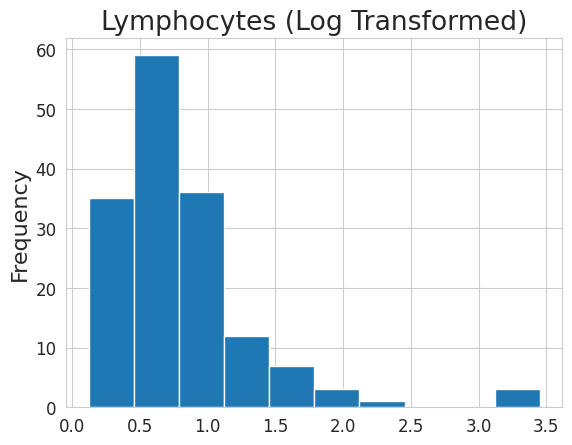

In [20]:
covid_flu['lymphocytes'].map(np.log1p).plot(
    title='Lymphocytes (Log Transformed)', kind='hist', xlabel='cells/μL'
)  # log transform of lymphocytes

#END-OF-TAIL IMPUTATION
End-of-tail imputation is a special type of arbitrary imputation in which the constant value we use to fill in missing values is based on the distribution of the feature. The value is at the end of the distribution. This method still has the benefit of calling out missing values as being different from the rest of the values (which is what imputing with the mean/median does) but also has the added benefit of making the values that we pick more automatically generated and easier to impute (figure 3.3):

If our variable is normally distributed, our arbitrary value is the mean + 3 × the standard deviation. Using 3 as a multiplier is common but also can be changed at the data scientist’s discretion.

If our data are skewed, then we can use the IQR (interquartile range) rule to place values at either end of the distribution by adding 1.5 times the IQR (which is the 75th percentile minus the 25th percentile) to the 75th or subtracting 1.5 times the IQR from the 25th percentile.

<Axes: title={'center': 'Lymphocytes (Imputed)'}, ylabel='Frequency'>

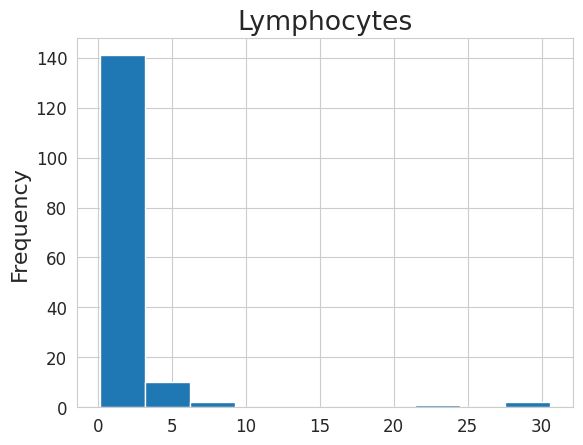

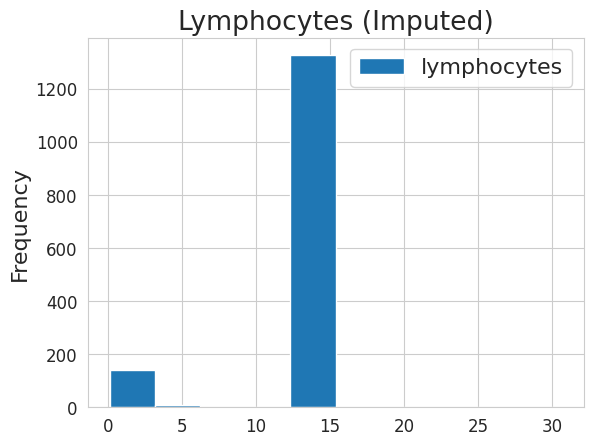

In [56]:
import matplotlib.pyplot as plt

from feature_engine.imputation import EndTailImputer

covid_flu['lymphocytes'].plot(
    title='Lymphocytes', kind='hist', xlabel='cells/μL'
)

EndTailImputer().fit_transform(covid_flu[['lymphocytes']]).plot(
    title='Lymphocytes (Imputed)', kind='hist', xlabel='cells/μL'
)

#BOX-COX TRANSFORMS

A less common, but oftentimes more useful transformation, is the Box-Cox transformation. The Box-Cox transformation is a transformation parameterized by a parameter lambda that will shift the shape of our data to be more normal.

In [21]:
covid_flu[covid_flu['Age']==0].head(3)  
covid_flu['Age'] = covid_flu['Age'] + 0.01  # to make Age strictly positive

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'neutrophil'}>],
       [<Axes: title={'center': 'serumLevelsOfWhiteBloodCell'}>,
        <Axes: title={'center': 'lymphocytes'}>],
       [<Axes: title={'center': 'DurationOfIllness'}>,
        <Axes: title={'center': 'Temperature'}>]], dtype=object)

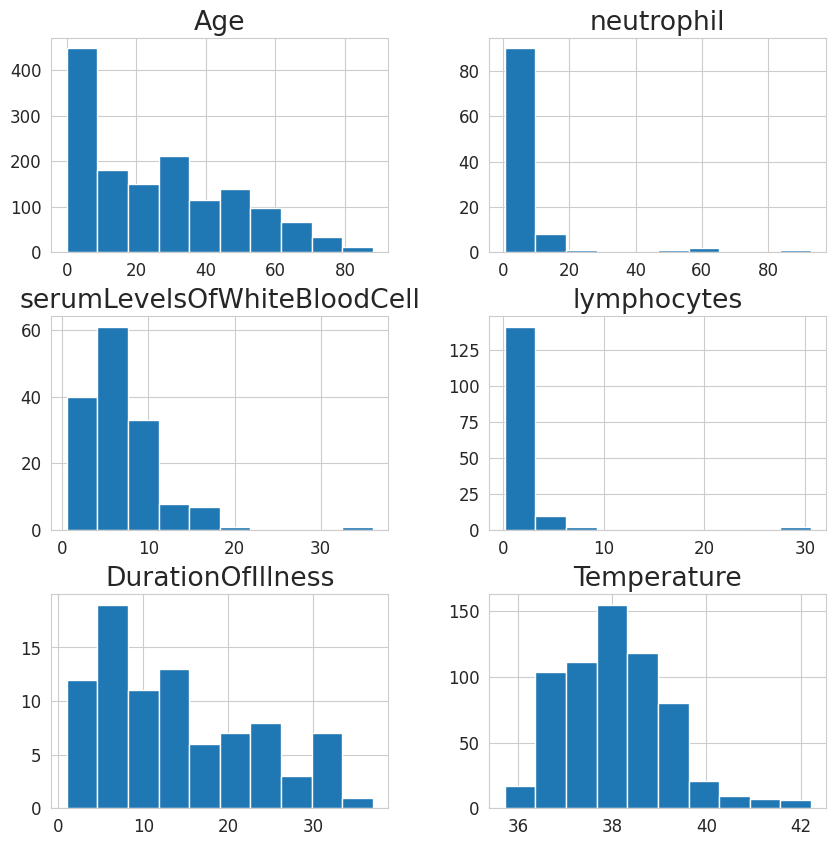

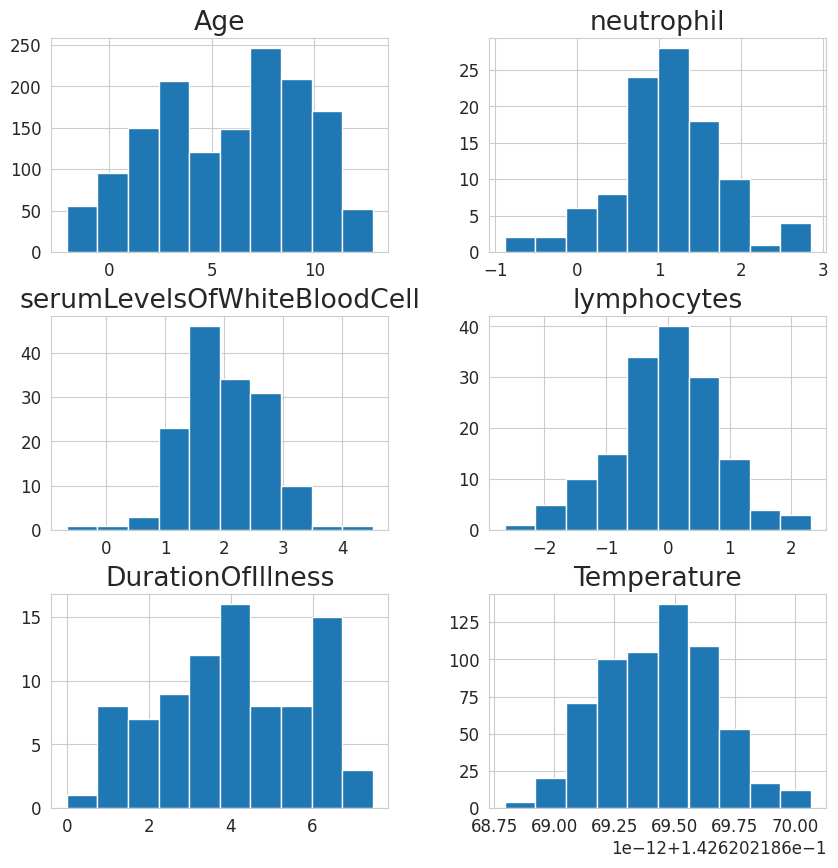

In [22]:
from sklearn.preprocessing import PowerTransformer

boxcox_transformer = PowerTransformer(method='box-cox', standardize=False)
pd.DataFrame(covid_flu[numerical_columns]).hist(figsize=(10, 10))

pd.DataFrame(
    boxcox_transformer.fit_transform(covid_flu[numerical_columns]), 
    columns=numerical_columns
).hist(figsize=(10, 10))

In [23]:
boxcox_transformer.lambdas_


array([ 0.41035252, -0.22261792,  0.12473207, -0.24415703,  0.36376995,
       -7.01162857])

In [24]:
# before any transformations, scales are all over the place as are means and standard deviations
covid_flu[numerical_columns].describe()   

,Age,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,DurationOfIllness,Temperature
count,1454.000000,103.000000,151.000000,156.000000,87.000000,628.000000
mean,26.481040,6.854078,6.885159,1.850154,13.988506,38.068312
std,21.487982,12.690131,4.346668,3.956668,9.043171,1.094468
min,0.010000,0.446000,0.500000,0.130000,1.000000,35.722222
25%,7.010000,2.160000,3.995000,0.637500,7.000000,37.222222
50%,24.010000,3.310000,5.690000,0.905500,12.000000,38.000000
75%,42.010000,6.645000,9.155000,1.605000,20.000000,38.722222
max,88.010000,93.000000,36.070000,30.600000,37.000000,42.222222


#NORMALIZING NEGATIVE DATA 

The PowerTransformer class also supports the Yeo-Johnson transformation, which also attempts to distort distributions to be more normal but has a modification in it that allows it to be utilized on negative data. Our data do not have any negatives in them, so we did not need to use it.

Feature transformations seem like they are a great catchall for forcing our data to be normal, but there are disadvantages to using the log and Box-Cox transformations:

We are distorting the original variable distribution, which may lead to decreased performance.

We are also changing various statistical measures, including the covariance between variables. This may become an issue when relying on techniques that use the covariance, like PCA.

Transformations run the risk of hiding outliers in our data, which may sound good at first but means that we lose control over dealing with outliers manually if we rely entirely on these transformations.



## FEATURE SCALING

In most datasets with numerical features, we run into the issue that the scales of the data are vastly different from one another, and some scales are just too big to be efficient. This can be an issue for algorithms where the distance between points is important, like in k-nearest neighbors (k-NN), k-means, or algorithms that rely on a gradient descent, like neural networks and SVMs.

Moving forward, we will talk about two kinds of standardization: min-max standardization and z-score standardization. Min-max standardization scales values in a feature to be between 0 and 1, while z-score standardization scales values to have a mean of 0 and a variance of 1, allowing for negative values. While min-max standardization ensures that each feature is on the same scale (from 0 to 1), z-score standardization ensures that outliers are handled more properly but will not guarantee that the data will end up on the exact same scale.

Both transformations do not affect the distribution of the feature like the log and Box-Cox transformations, and they both help deal with the effects of outliers on our models. Min-max standardization has a harder time dealing with outliers

In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
pd.DataFrame(  # mean and std are different but min and max are 0s and 1s
    MinMaxScaler().fit_transform(covid_flu[numerical_columns]),
    columns=numerical_columns
).describe()

,Age,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,DurationOfIllness,Temperature
count,1454.000000,103.000000,151.000000,156.000000,87.000000,628.000000
mean,0.300807,0.069236,0.179510,0.056454,0.360792,0.360937
std,0.244182,0.137111,0.122200,0.129855,0.251199,0.168380
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.079545,0.018519,0.098257,0.016656,0.166667,0.230769
50%,0.272727,0.030944,0.145909,0.025451,0.305556,0.350427
75%,0.477273,0.066977,0.243323,0.048408,0.527778,0.461538
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#Constructing categorical data

In [26]:
categorical_types = ['O']  # Just the "object" type

categorical_columns = covid_flu.select_dtypes(include=categorical_types).columns.tolist()

categorical_columns.remove('Diagnosis')  # our response variable

for categorical_column in categorical_columns:
    print('=======')
    print(categorical_column)
    print('=======')
    print(covid_flu[categorical_column].value_counts(dropna=False))
    

InitialPCRDiagnosis
NaN    1378
Yes     100
No        4
Name: InitialPCRDiagnosis, dtype: int64
Sex
M      748
F      658
NaN     76
Name: Sex, dtype: int64
CReactiveProteinLevels
NaN           1345
8                3
0.5              3
15               3
111              2
              ... 
5.78             1
67.62            1
13.2 mg/dL       1
21.27            1
0.6              1
Name: CReactiveProteinLevels, Length: 121, dtype: int64
CTscanResults
NaN    1323
Yes     144
No       15
Name: CTscanResults, dtype: int64
RiskFactors
NaN                                                                   1273
asthma                                                                  36
pneumonia                                                               21
immuno                                                                  21
diabetes                                                                16
                                                                      ... 
diabetes,

In [27]:
# Turn our Sex column into a binary column
covid_flu['Female'] = covid_flu['Sex'] == 'F'
del covid_flu['Sex']

In [31]:
covid_flu = covid_flu.replace({'Yes': True, 'No': False})  # replace yes and  no with True / False

covid_flu.head(3)

,Diagnosis,InitialPCRDiagnosis,Age,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,CReactiveProteinLevels,DurationOfIllness,CTscanResults,RiskFactors,...,Diarrhea,Fever,Coughing,ShortnessOfBreath,SoreThroat,NauseaVomitting,Temperature,Fatigue,Female,FluSymptoms
0,H1N1,NaN,67.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,True,True,NaN,False,NaN,38.111111,False,True,False
1,H1N1,NaN,29.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2,H1N1,NaN,22.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False


In [41]:
# construct a new categorical column that is an amalgamation of several flu symptoms
covid_flu['FluSymptoms'] = covid_flu[['Diarrhea', 'Fever', 'Coughing', 'SoreThroat', 'NauseaVomitting', 'Fatigue']].sum(axis=1) >= 2

print(covid_flu['FluSymptoms'].value_counts())

print(covid_flu['FluSymptoms'].isnull().sum())  # no missing values

binary_features = [  # aggregate all binary columns in a list
    'Female', 'GroundGlassOpacity', 'CTscanResults', 'Diarrhea', 'Fever', 'FluSymptoms',
    'Coughing', 'SoreThroat', 'NauseaVomitting', 'Fatigue', 'InitialPCRDiagnosis'
]

False    753
True     729
Name: FluSymptoms, dtype: int64
0


Mean: 741.0 
Median: 741.0 
Max: 824


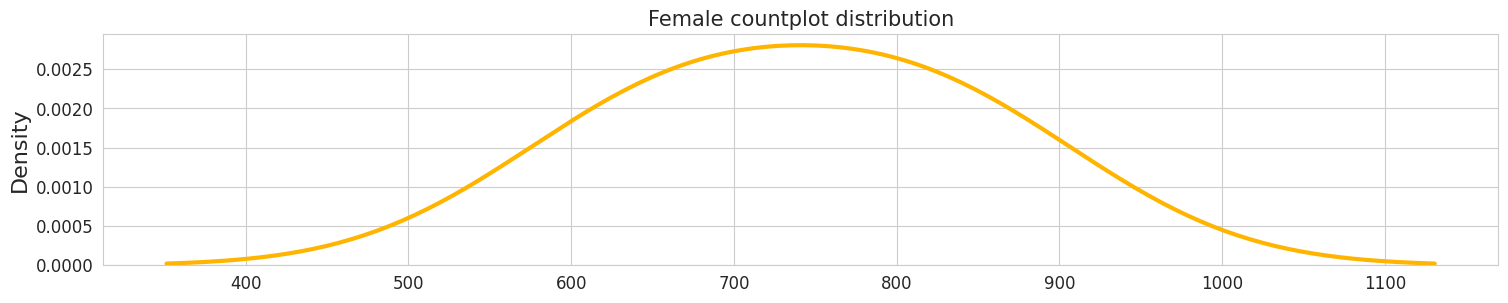

Mean: 46.5 
Median: 46.5 
Max: 90


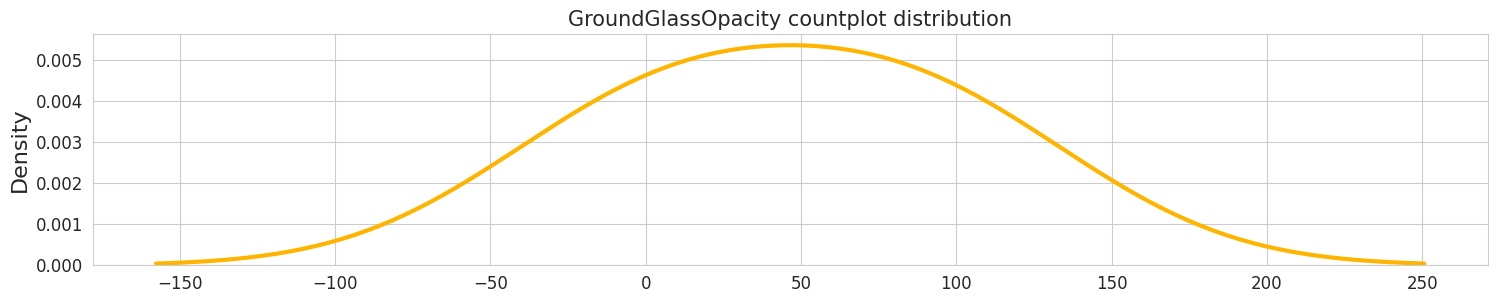

Mean: 79.5 
Median: 79.5 
Max: 144


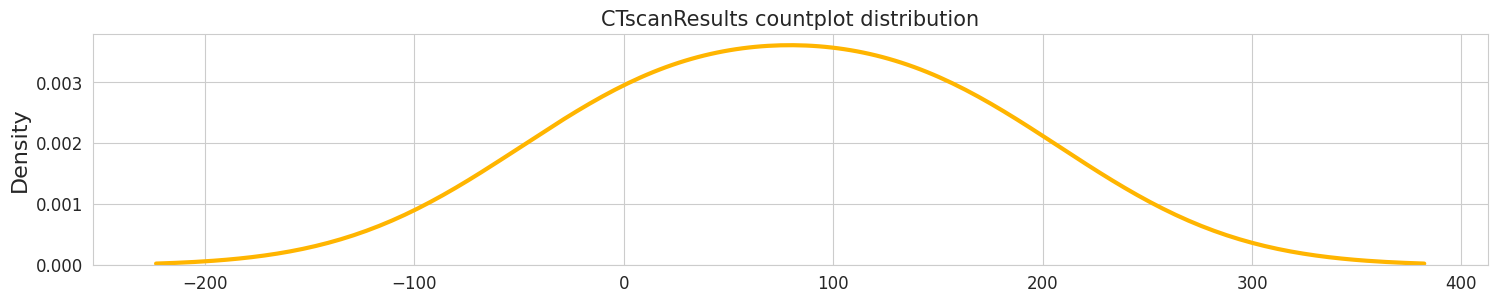

Mean: 225.0 
Median: 225.0 
Max: 340


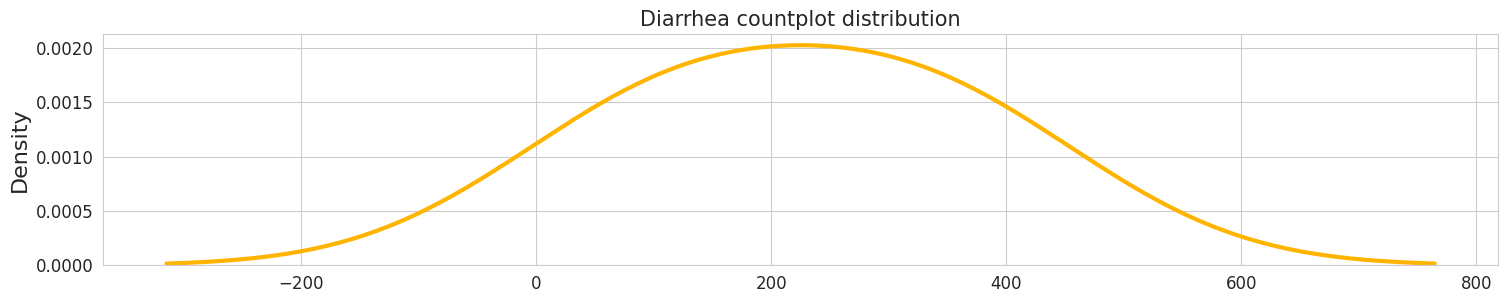

Mean: 461.5 
Median: 461.5 
Max: 777


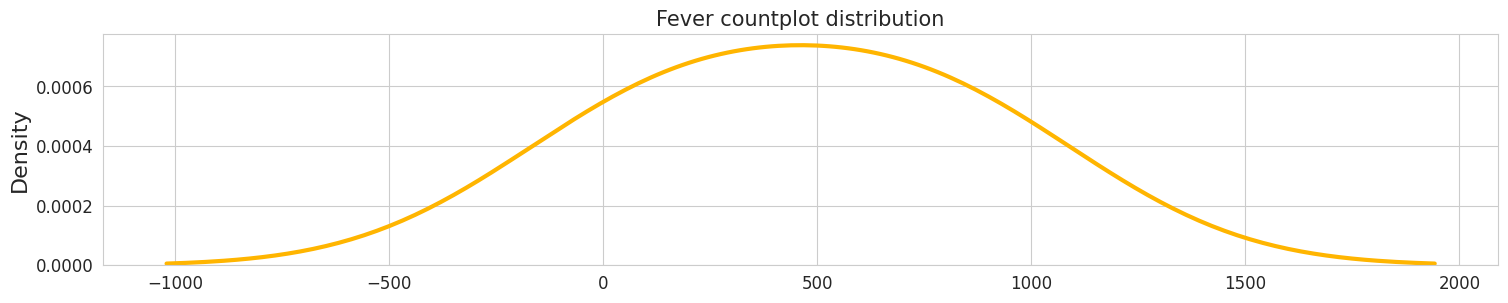

Mean: 741.0 
Median: 741.0 
Max: 753


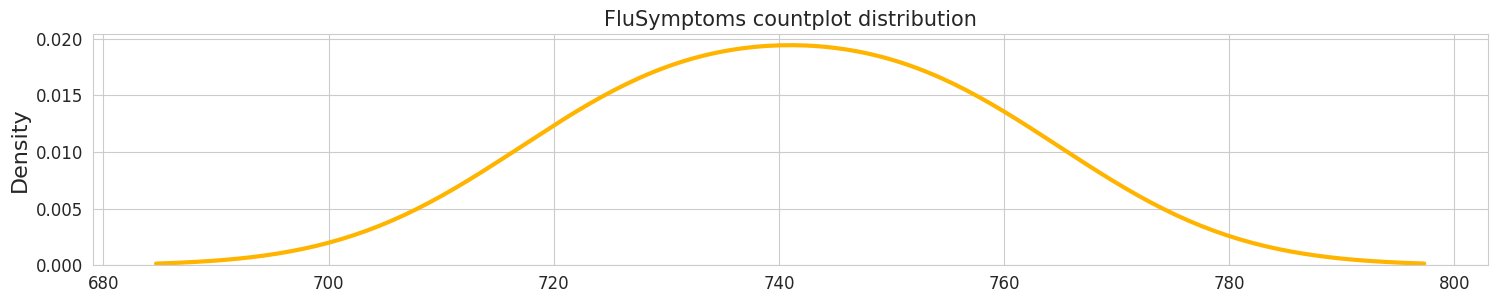

Mean: 429.5 
Median: 429.5 
Max: 745


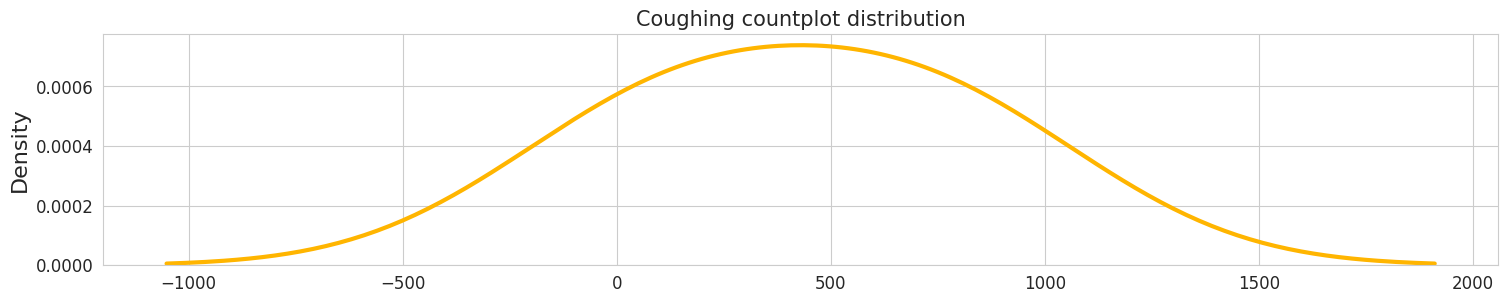

Mean: 335.0 
Median: 335.0 
Max: 407


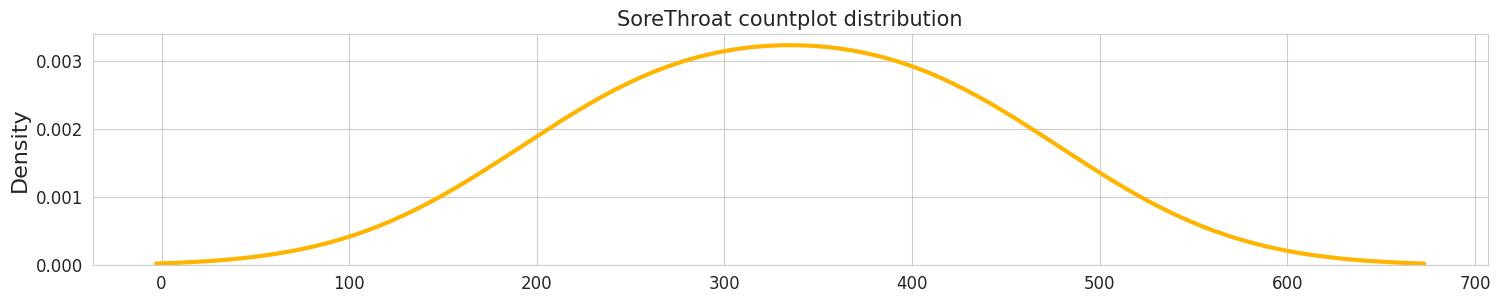

Mean: 210.5 
Median: 210.5 
Max: 319


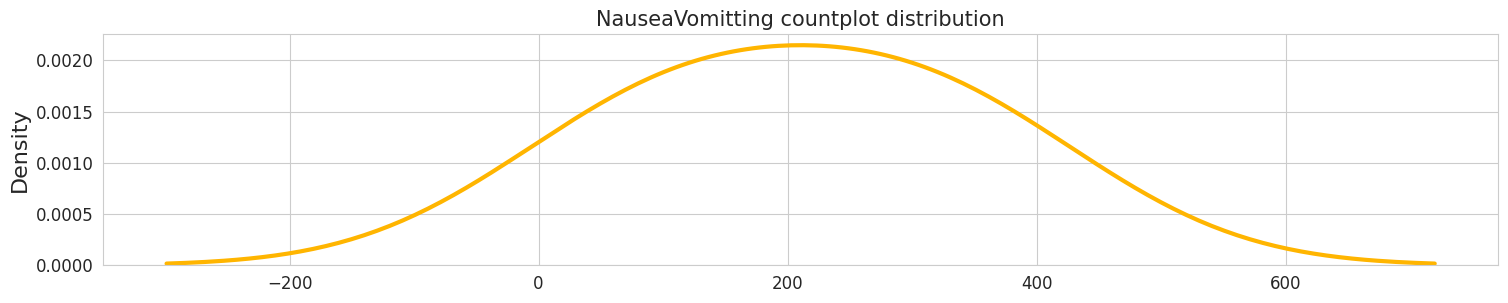

Mean: 265.5 
Median: 265.5 
Max: 348


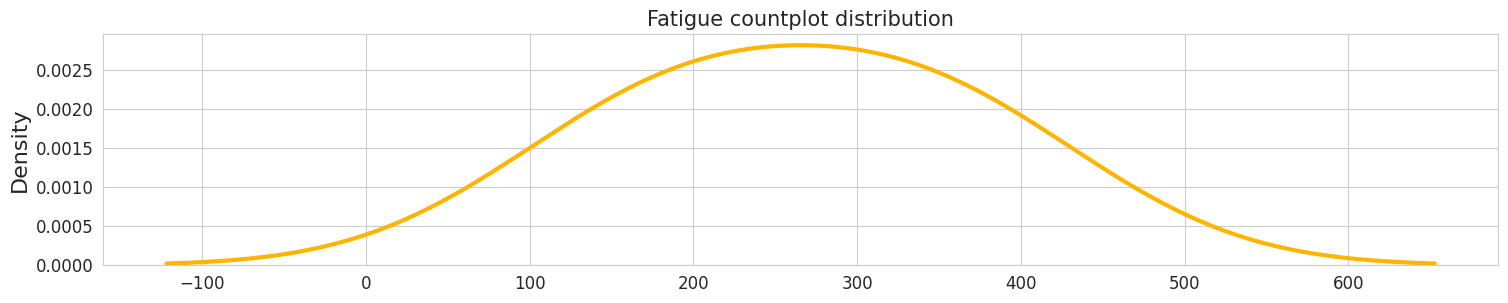

Mean: 52.0 
Median: 52.0 
Max: 100


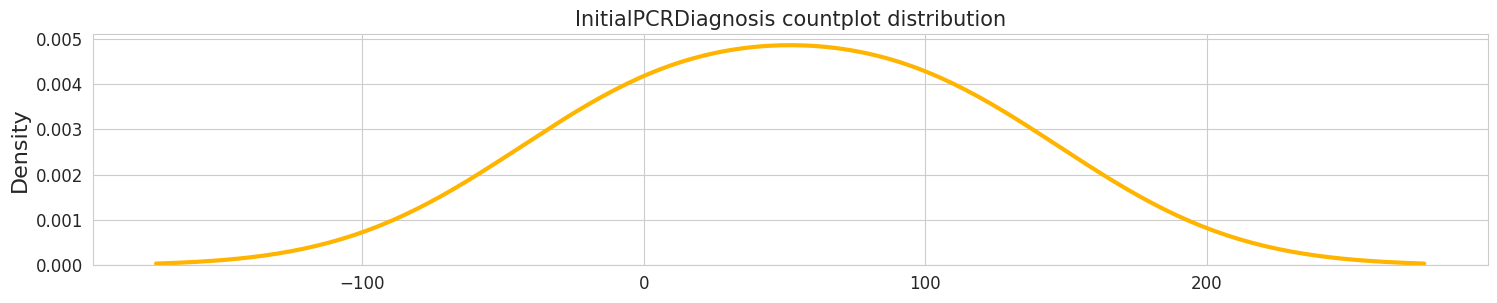

In [42]:
for feature in binary_features:
    distplot_features(covid_flu, feature=feature, title = feature + " countplot distribution", color = custom_colors[3], categorical=True)

In [35]:
# A custom data transformer to deal with our messy risk factor column

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer  # class to help make dummy variables
from functools import reduce

class DummifyRiskFactor(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.label_binarizer = None
        
    def parse_risk_factors(self, comma_sep_factors):
        ''' asthma,heart disease -> ['asthma', 'heart disease'] '''
        try:
            return [s.strip().lower() for s in comma_sep_factors.split(',')]
        except:
            return []
    
    def fit(self, X, y=None):
        self.label_binarizer = MultiLabelBinarizer()
        self.label_binarizer.fit(X.apply(self.parse_risk_factors))  # create dummy variable for each risk factor
        return self
    
    def transform(self, X, y=None):
        return self.label_binarizer.transform(X.apply(self.parse_risk_factors))

A custom data transformer to deal with our messy RiskFactors column

❷ Class to help make dummy variables

❸ Creates a dummy variable for each risk factor

Our DummifyRiskFactor transformer works by first applying the fit method to data. The fit method will

Normalize the RiskFactors text by setting it in lowercase

Separate the now lowercase string by comma

Apply the MultiLabelBinarizer class from scikit-learn to create dummy variables for each risk factor

We can then use the transform method in our custom transformer to map a list of messy risk factor strings to a neat matrix of risk factors! Let’s use our transformer just like any other scikit-learn transformer, as shown in the following listing.

In [36]:
drf = DummifyRiskFactor()

risks = drf.fit_transform(covid_flu['RiskFactors'])

print(risks.shape)

pd.DataFrame(risks, columns=drf.label_binarizer.classes_)

(1482, 41)


,asthma,athero,atopic dermatitis and repetitive respiratory infections,begin tumor (removed),chronic,chronic endrocrine disorder,chronic liver dieseas,chronic liver disorder,chronic neurological disorders,chronic obstructive pulmonary disease,...,lung disease,myxoma of abdominal cavity,obesity,pneumomediastinum and subcutaneous emphysema,pneumonia,pre-eclampsia,prom,renal disease,respiratory disease,rheumatoid arthritis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1480,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can also pretty quickly notice that this matrix will be pretty sparse. When we get to our feature selection portion of this chapter, we will attempt to remove unnecessary features to try and reduce sparsity.

#Building our feature engineering pipeline

In [37]:
from sklearn.model_selection import train_test_split

X, y = covid_flu.drop(['Diagnosis'], axis=1), covid_flu['Diagnosis']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=0, test_size=.2
)

In [38]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

# deal with risk factors

risk_factor_pipeline = Pipeline(
    [
        ('select_risk_factor', FunctionTransformer(lambda df: df['RiskFactors'])),
        ('dummify', DummifyRiskFactor())
    ]
)

# deal with binary columns

binary_pipeline = Pipeline(
    [
        ('select_categorical_features', FunctionTransformer(lambda df: df[binary_features])),
        ('fillna', SimpleImputer(strategy='constant', fill_value=False))  # assume missing values are not present
    ]
)

# deal with numerical columns

numerical_pipeline = Pipeline(
    [
        ('select_numerical_features', FunctionTransformer(lambda df: df[numerical_columns])),
        ('impute', SimpleImputer(strategy='median')),
    ]
)

In [49]:
# only using numerical values has a good precision on COVID class but awful recall..
simple_grid_search(x_train, y_train, x_test, y_test, numerical_pipeline)

Parsing took 0.02 seconds
Training took 10.36 seconds
              precision    recall  f1-score   support

     COVID19       0.78      0.73      0.75        82
        H1N1       0.90      0.92      0.91       215

    accuracy                           0.87       297
   macro avg       0.84      0.83      0.83       297
weighted avg       0.87      0.87      0.87       297

Overall took 10.39 seconds


ExtraTreesClassifier()

In [50]:
# only using risk factors has a horrible recall and accuracy is barely higher than the null accuracy
simple_grid_search(x_train, y_train, x_test, y_test, risk_factor_pipeline)

Parsing took 0.01 seconds
Training took 9.93 seconds
              precision    recall  f1-score   support

     COVID19       0.80      0.10      0.17        82
        H1N1       0.74      0.99      0.85       215

    accuracy                           0.74       297
   macro avg       0.77      0.54      0.51       297
weighted avg       0.76      0.74      0.66       297

Overall took 9.95 seconds


ExtraTreesClassifier(n_estimators=50)

In [51]:
print(simple_grid_search(x_train, y_train, x_test, y_test, binary_pipeline))

Parsing took 0.01 seconds
Training took 9.67 seconds
              precision    recall  f1-score   support

     COVID19       0.82      0.60      0.69        82
        H1N1       0.86      0.95      0.90       215

    accuracy                           0.85       297
   macro avg       0.84      0.77      0.80       297
weighted avg       0.85      0.85      0.84       297

Overall took 9.69 seconds
ExtraTreesClassifier(max_depth=10)


In [52]:
# Use our cross-validation function to show the best classification report (best == highest test set accuracy)
# We  will use this as a baseline performance indicator for our next feature engineering attempts

simple_fe = FeatureUnion([  # put all of our features together
    ('risk_factors', risk_factor_pipeline),
    ('binary_pipeline', binary_pipeline),
    ('numerical_pipeline', numerical_pipeline)
])

simple_fe.fit_transform(x_train, y_train).shape

best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe)

Parsing took 0.03 seconds
Training took 11.47 seconds
              precision    recall  f1-score   support

     COVID19       0.85      0.85      0.85        82
        H1N1       0.94      0.94      0.94       215

    accuracy                           0.92       297
   macro avg       0.90      0.90      0.90       297
weighted avg       0.92      0.92      0.92       297

Overall took 11.49 seconds


In [53]:
numerical_pipeline = Pipeline(
    [
        ('select_numerical_features', FunctionTransformer(lambda df: df[numerical_columns])),
        ('impute', SimpleImputer(strategy='mean')),  # try mean instead of median
        ('scale', StandardScaler())  # scale our numerical features
    ]
)

simple_fe = FeatureUnion([
    ('risk_factors', risk_factor_pipeline),
    ('binary_pipeline', binary_pipeline),
    ('numerical_pipeline', numerical_pipeline)
])

# gained some precision for the COVID class
best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe)

Parsing took 0.02 seconds
Training took 11.56 seconds
              precision    recall  f1-score   support

     COVID19       0.85      0.84      0.85        82
        H1N1       0.94      0.94      0.94       215

    accuracy                           0.92       297
   macro avg       0.90      0.89      0.89       297
weighted avg       0.92      0.92      0.92       297

Overall took 11.64 seconds


Our model got slower, and performance is not as good. Looks like this isn’t the way to go here. How about imputing our missing values with an arbitrary 999 (figure 3.24) and then applying a scaling to reduce the impact of the outliers we are introducing?

In [54]:
numerical_pipeline = Pipeline(
    [
        ('select_numerical_features', FunctionTransformer(lambda df: df[numerical_columns])),
        ('impute', SimpleImputer(strategy='constant', fill_value=999)),  # try a constant 999
        ('scale', StandardScaler())
    ]
)

simple_fe = FeatureUnion([
    ('risk_factors', risk_factor_pipeline),
    ('binary_pipeline', binary_pipeline),
    ('numerical_pipeline', numerical_pipeline)
])

# gained some precision for the COVID class
best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe)

Parsing took 0.04 seconds
Training took 11.46 seconds
              precision    recall  f1-score   support

     COVID19       0.89      0.87      0.88        82
        H1N1       0.95      0.96      0.95       215

    accuracy                           0.93       297
   macro avg       0.92      0.91      0.92       297
weighted avg       0.93      0.93      0.93       297

Overall took 11.53 seconds


In [57]:
numerical_pipeline = Pipeline(
    [
        ('select_numerical_features', FunctionTransformer(lambda df: df[numerical_columns])),
        ('box-cox', PowerTransformer(method='box-cox', standardize=True)),
        ('turn_into_df', FunctionTransformer(lambda matrix: pd.DataFrame(matrix))),  # turn back into dataframe
        ('end_of_tail', EndTailImputer(imputation_method='gaussian'))

    ]
)

simple_fe = FeatureUnion([
    ('risk_factors', risk_factor_pipeline),
    ('binary_pipeline', binary_pipeline),
    ('numerical_pipeline', numerical_pipeline)
])

# looking better
best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe)

Parsing took 0.08 seconds
Training took 12.92 seconds
              precision    recall  f1-score   support

     COVID19       0.79      0.88      0.83        82
        H1N1       0.95      0.91      0.93       215

    accuracy                           0.90       297
   macro avg       0.87      0.89      0.88       297
weighted avg       0.91      0.90      0.90       297

Overall took 12.94 seconds


<Axes: title={'center': 'Age (Uniform Binning)'}, ylabel='Frequency'>

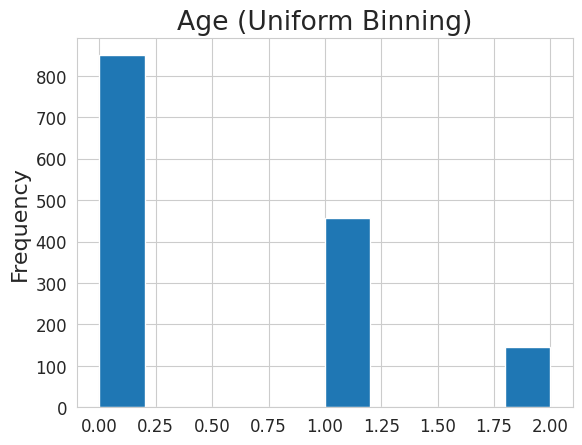

In [58]:
from sklearn.preprocessing import KBinsDiscretizer  # we will use this module for binning our data

# uniform will create bins of equal width
binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
binned_data = binner.fit_transform(covid_flu[['Age']].dropna())
pd.Series(binned_data.reshape(-1,)).plot(
    title='Age (Uniform Binning)', kind='hist', xlabel='Age'
)

In [59]:
numerical_pipeline = Pipeline(  # bin data after scaling and imputing
    [
        ('select_numerical_features', FunctionTransformer(lambda df: df[numerical_columns])),
        ('box-cox', PowerTransformer(method='box-cox', standardize=True)),
        ('turn_into_df', FunctionTransformer(lambda matrix: pd.DataFrame(matrix))),  # turn back into dataframe
        ('end_of_tail', EndTailImputer(imputation_method='gaussian')),
        ('ordinal_bins', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans'))
    ]
)

simple_fe = FeatureUnion([
    ('risk_factors', risk_factor_pipeline),
    ('binary_pipeline', binary_pipeline),
    ('numerical_pipeline', numerical_pipeline)
])

# so far one of our best set of results!
best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe)

Parsing took 0.31 seconds
Training took 13.36 seconds
              precision    recall  f1-score   support

     COVID19       0.84      0.84      0.84        82
        H1N1       0.94      0.94      0.94       215

    accuracy                           0.91       297
   macro avg       0.89      0.89      0.89       297
weighted avg       0.91      0.91      0.91       297

Overall took 13.44 seconds


#Feature selection


In [60]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

risk_factor_pipeline = Pipeline(  # add feature selection
    [
        ('select_risk_factor', FunctionTransformer(lambda df: df['RiskFactors'])),
        ('dummify', DummifyRiskFactor()),
        ('mutual_info', SelectKBest(mutual_info_classif, k=20)),  # feature selection based on mutual information
    ]
)


simple_fe = FeatureUnion([
    ('risk_factors', risk_factor_pipeline),
    ('binary_pipeline', binary_pipeline),
    ('numerical_pipeline', numerical_pipeline)
])

best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe)

Parsing took 0.70 seconds
Training took 11.93 seconds
              precision    recall  f1-score   support

     COVID19       0.87      0.82      0.84        82
        H1N1       0.93      0.95      0.94       215

    accuracy                           0.92       297
   macro avg       0.90      0.89      0.89       297
weighted avg       0.91      0.92      0.91       297

Overall took 11.95 seconds


#Hypothesis testing

Another method for feature selection is to utilize the chi-squared test, which is a statistical test that works only on categorical data and is used to test for independence between two variables. In ML, we can use the chi-squared test to select features that the test deems the most dependent on the response, implying that it is useful in predicting the response variable.

In [61]:
from sklearn.feature_selection import chi2

risk_factor_pipeline = Pipeline(  # add feature selection
    [
        ('select_risk_factor', FunctionTransformer(lambda df: df['RiskFactors'])),
        ('dummify', DummifyRiskFactor()),
        ('chi2', SelectKBest(chi2, k=10))  # use chi2 to select features
    ]
)


simple_fe = FeatureUnion([
    ('risk_factors', risk_factor_pipeline),
    ('binary_pipeline', binary_pipeline),
    ('numerical_pipeline', numerical_pipeline)
])

best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe)

Parsing took 0.07 seconds
Training took 11.71 seconds
              precision    recall  f1-score   support

     COVID19       0.98      0.74      0.85        82
        H1N1       0.91      1.00      0.95       215

    accuracy                           0.93       297
   macro avg       0.95      0.87      0.90       297
weighted avg       0.93      0.93      0.92       297

Overall took 11.73 seconds


In [62]:
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier

risk_factor_pipeline = Pipeline(
    [
        ('select_risk_factor', FunctionTransformer(lambda df: df['RiskFactors'])),
        ('dummify', DummifyRiskFactor()),
        # use a decision tree classifier to select features
        ('tree_selector', SelectFromModel(max_features=20, estimator=DecisionTreeClassifier()))
    ]
)


simple_fe = FeatureUnion([
    ('risk_factors', risk_factor_pipeline),
    ('binary_pipeline', binary_pipeline),
    ('numerical_pipeline', numerical_pipeline)
])

# let's stop here
best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe)

Parsing took 0.52 seconds
Training took 11.53 seconds
              precision    recall  f1-score   support

     COVID19       0.85      0.84      0.85        82
        H1N1       0.94      0.94      0.94       215

    accuracy                           0.92       297
   macro avg       0.90      0.89      0.89       297
weighted avg       0.92      0.92      0.92       297

Overall took 11.60 seconds


In [63]:
# Let's take a look at our pipeline
simple_fe.transformer_list

[('risk_factors',
  Pipeline(steps=[('select_risk_factor',
                   FunctionTransformer(func=<function <lambda> at 0x7fceb9229ee0>)),
                  ('dummify', DummifyRiskFactor()),
                  ('tree_selector',
                   SelectFromModel(estimator=DecisionTreeClassifier(),
                                   max_features=20))])),
 ('binary_pipeline',
  Pipeline(steps=[('select_categorical_features',
                   FunctionTransformer(func=<function <lambda> at 0x7fcebed954c0>)),
                  ('fillna',
                   SimpleImputer(fill_value=False, strategy='constant'))])),
 ('numerical_pipeline',
  Pipeline(steps=[('select_numerical_features',
                   FunctionTransformer(func=<function <lambda> at 0x7fcebbdb40d0>)),
                  ('box-cox', PowerTransformer(method='box-cox')),
                  ('turn_into_df',
                   FunctionTransformer(func=<function <lambda> at 0x7fcebbdb4790>)),
                  ('end_of_tail', 